#Initialization of the kaggle and the files#

In [ ]:
# reading in the data via the Kaggle API

# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# install Kaggle
! pip install kaggle

Log into your Kaggle account, go to Account > API > Create new API token. You will obtain a kaggle.json file, which you save on your Google Drive directy in my drive.

In [ ]:
!mkdir ~/.kaggle

In [ ]:
#read in your Kaggle credentials from Google Drive
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json


In [ ]:
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

100% 303k/303k [00:00<00:00, 475kB/s]
100% 303k/303k [00:00<00:00, 475kB/s]


# Begining of the model#

In [ ]:
!pip install transformers torch
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00


## Imports##

In [ ]:
# read in your training data
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

from transformers import CamembertTokenizer, CamembertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



df = pd.read_csv('training_data.csv', index_col = 'id')
df_pred = pd.read_csv('unlabelled_test_data.csv', index_col = 'id')

In [ ]:
df

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2


###CamemBert model
######After we used the bert model with the 'bert-base-multilingual-cased' pre-trained model we decided to use a model who is specific to the french to see the difference of these two model.

#####Frist we configure correctly our data to be used in our model. As always we separe our train and test data set with the same parameters to be constant in the comparaison. And then we encode our data

In [ ]:
X = df['sentence']
y = df['difficulty']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = X_train.tolist()
X_test = X_test.tolist()

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


#####As we had some problems for this model with number of classes. We just did some verification about the class labels that were input in our model. We should have 6 different classes.

In [ ]:
num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)

Number of classes: 6


#####Here we create our tokennizer,dataloaders who will be put in the model to be train and then we configure our training using Adamw as optimizer and CrossEntropyLoss function as our loss fuction.

#####Like the bert model we use the GPU for this model. But we had some problems to run our model on the GPU so we did also some verification to be sure that our model runned on the GPU

In [ ]:
camembert_tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
X_train_encoding = camembert_tokenizer(X_train, truncation=True, padding=True, return_tensors="pt")
X_test_encoding = camembert_tokenizer(X_test, truncation=True, padding=True, return_tensors="pt")

X_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

X_train_dataset = TensorDataset(X_train_encoding['input_ids'], X_train_encoding['attention_mask'], X_train_tensor)
X_test_dataset = TensorDataset(X_test_encoding['input_ids'], X_test_encoding['attention_mask'], X_test_tensor)

X_train_loader = DataLoader(X_train_dataset, batch_size=16, shuffle=True)
X_test_loader = DataLoader(X_test_dataset, batch_size=16)

camembert_model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

camembert_model = camembert_model.to(device)

optimizer = AdamW(camembert_model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()



sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


#####After the creation of our model we can train our CamemBert model

In [ ]:
for epoch in range(3):
    for batch in X_train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        difficulty_level = batch[2].to(device)

        camembert_model.train()

        outputs = camembert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, difficulty_level)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.no_grad()
torch.save(camembert_model.state_dict(), 'model_camembert.pth')

#####Here we download the camembert model in pth format to be used in streamlit

In [ ]:
files.download('model_camembert.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Here we evaluate our model

In [ ]:

camembert_model.eval()
true_difficulty_levels=[]
pred_difficulty_level=[]

with torch.no_grad():
    validation_loss = 0.0
    for batch in X_test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        difficulty_level = batch[2].to(device)

        outputs = camembert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, difficulty_level)
        preds = torch.argmax(logits, dim=1)

        true_difficulty_levels.extend(difficulty_level.cpu().numpy())
        pred_difficulty_level.extend(preds.cpu().numpy())
        validation_loss += loss.item()


In [ ]:
validation_loss /= len(X_test_loader)
accuracy = accuracy_score(true_difficulty_levels, pred_difficulty_level)
precision=precision_score(true_difficulty_levels, pred_difficulty_level, average='macro')
recall=recall_score(true_difficulty_levels, pred_difficulty_level, average='macro')
f1= f1_score(true_difficulty_levels, pred_difficulty_level, average='macro')

print(f'validation loss: {round(validation_loss,4)}')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")


validation loss: 1.0654
Precision: 0.5806505585595948
Recall: 0.5681968468081058
F1-Score: 0.5643794913182132
Accuracy: 0.5739583333333333


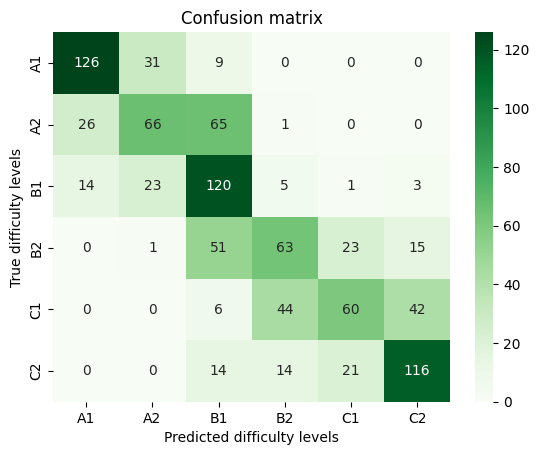

In [ ]:
conf_matrix = confusion_matrix(true_difficulty_levels, pred_difficulty_level)
difficulty_labels=["A1","A2","B1","B2","C1","C2"]
sns.heatmap(conf_matrix, annot=True, fmt='g',xticklabels=difficulty_labels,yticklabels=difficulty_labels,cmap="Greens")
plt.xlabel('Predicted difficulty levels')
plt.ylabel('True difficulty levels')
plt.title('Confusion matrix')
plt.show()

#####Now we prdict our model on our unlabelled data

In [ ]:
# Supposons que new_texts est votre nouveau dataset contenant des phrases à prédire
sentence_to_predict = df_pred['sentence'].tolist()

# Tokenisation des nouvelles phrases
sentence_to_predict_tokenized = camembert_tokenizer(sentence_to_predict, truncation=True, padding=True, return_tensors="pt")

# Création du TensorDataset
pred_tensor_dataset = TensorDataset(sentence_to_predict_tokenized['input_ids'], sentence_to_predict_tokenized['attention_mask'])

# Création du DataLoader
pred_loader = DataLoader(pred_tensor_dataset, batch_size=16)

# Prédiction
predictions = []
camembert_model.eval()
with torch.no_grad():
    for batch in pred_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        outputs = camembert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())






##### The prediction is made in our encoder difficulty label so we inverse the encoding to have our initial labels

In [ ]:
predictions = label_encoder.inverse_transform(predictions)
predictions

array(['C2', 'B1', 'B1', ..., 'C2', 'B2', 'B2'], dtype=object)

#####Data preparation (Label encoder, train,test split). The label was encoded like this

*   A1:0
*   A2:1
*   B1:2
*   B2:3
*   C1:4
*   C2:5

#####Now we can train our model


In [ ]:
predictions
df_pred['difficulty']=predictions

# This is how to submit a pd file with predictions
### for the example we will submit a file where only A1 is given as a prediction

In [ ]:
df_sub=df_pred[['difficulty']]
df_sub.to_csv('submission.csv')

In [ ]:
! kaggle competitions submit -c detecting-french-texts-difficulty-level-2023 -f submission.csv -m "Sample submission"

100% 8.30k/8.30k [00:02<00:00, 2.95kB/s]
Successfully submitted to Detecting the difficulty level of French texts

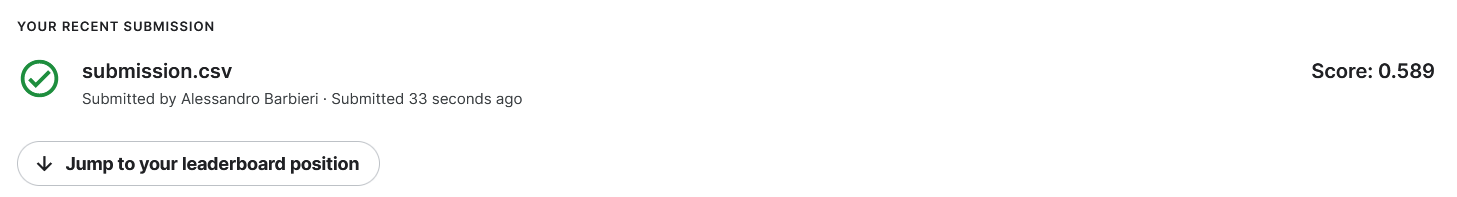